<a href="https://colab.research.google.com/github/idoncode/CNN_with_Transfer_Learning/blob/main/Transfer_Learning_Part_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 1: Feature  Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benifits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
## Are we using a GPU
!nvidia-smi

Mon Oct  9 07:47:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-10-09 07:47:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   148MB/s    in 1.1s    

2023-10-09 07:47:06 (148 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directort and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry

## Create data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print('Training images: ')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')
print('Testing images: ')
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'categorical')

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training(before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import tensorflow as tf
import datetime


def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name +  '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to: {log_dir}')
  return tensorboard_callback

**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using Tensorflow Hub

In the past we've used Tensorflow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are goingto come from Tensorflow Hub.
We can access pretrained models on: https://tfhub.dev/


Browsing the TensorFlow Hub page and sorting for image classification, we found the feature vector models

In [ ]:
## Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL

def create_model(model_url, num_classes = 10):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes (default = 10).

  Returns:
    An uncompiled Keras Seqeuntial model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  '''
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable = False,      # freeze the already learned patterns
                                           name = 'feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE+(3,))  ## Tip (224, 224, 3)

  # Create our own model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      tf.keras.layers.Dense(num_classes,
                            activation = 'softmax',
                            name = 'output_layer')
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes) # 10

In [ ]:
# Compile our resnet model
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
# Let's fit our Resnet model to the data (10 percent of 10 classes)
history_1 = resnet_model.fit(train_data_10_percent,
                             epochs = 5,
                             steps_per_epoch = len(train_data_10_percent),
                             validation_data = test_data,
                             validation_steps = len(test_data),
                             callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                      experiment_name = 'resnet50V2')])

Saving Tensorboard log files to: tensorflow_hub/resnet50V/20231009-081456
Epoch 1/5
24/24 [==============================] - 26s 571ms/step - loss: 2.0449 - accuracy: 0.3320 - val_loss: 1.2490 - val_accuracy: 0.6040
Epoch 2/5
24/24 [==============================] - 11s 463ms/step - loss: 0.9575 - accuracy: 0.6960 - val_loss: 0.8858 - val_accuracy: 0.7160
Epoch 3/5
24/24 [==============================] - 11s 464ms/step - loss: 0.6519 - accuracy: 0.8067 - val_loss: 0.7584 - val_accuracy: 0.7564
Epoch 4/5
24/24 [==============================] - 11s 450ms/step - loss: 0.4965 - accuracy: 0.8773 - val_loss: 0.7180 - val_accuracy: 0.7672
Epoch 5/5
24/24 [==============================] - 11s 460ms/step - loss: 0.4021 - accuracy: 0.9013 - val_loss: 0.6747 - val_accuracy: 0.7812


Our transfer learning feature extractor model out performed ALL of the previous models we built by hand .. and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Lets create a function to plot our loss curves ...
# You could put a function like this into a script called 'helper.py' and import
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  '''
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots a training/validation loss and accuracy metrics.
  '''

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

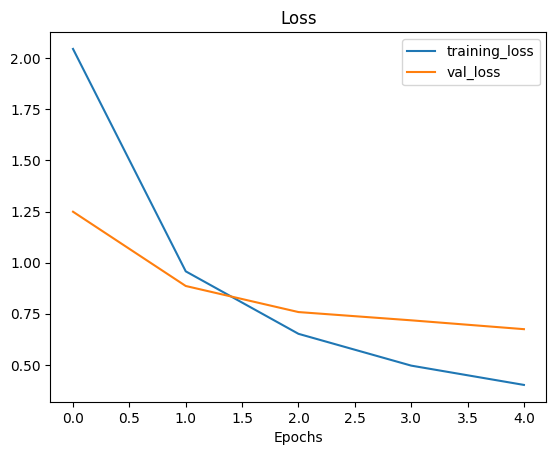

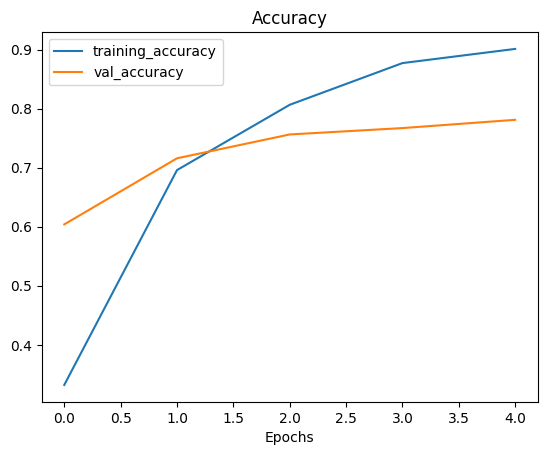

In [ ]:
plot_loss_curves(history_1)

### Creating and testing EfficientNet B0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientnetB0 feature extractor model
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

# Fit EfficientNet model to 10% of training data
history_2 = efficientnet_model.fit(train_data_10_percent,
                                   epochs = 5,
                                   steps_per_epoch = len(train_data_10_percent),
                                   validation_data = test_data,
                                   validation_steps = len(test_data),
                                   callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                            experiment_name = 'EfficientNetB0')])

Saving Tensorboard log files to: tensorflow_hub/EfficientNetB0/20231009-083631
Epoch 1/5
24/24 [==============================] - 22s 507ms/step - loss: 1.8279 - accuracy: 0.4360 - val_loss: 1.2597 - val_accuracy: 0.7600
Epoch 2/5
24/24 [==============================] - 10s 414ms/step - loss: 1.0334 - accuracy: 0.7880 - val_loss: 0.8479 - val_accuracy: 0.8300
Epoch 3/5
24/24 [==============================] - 10s 443ms/step - loss: 0.7436 - accuracy: 0.8373 - val_loss: 0.6826 - val_accuracy: 0.8464
Epoch 4/5
24/24 [==============================] - 9s 396ms/step - loss: 0.5963 - accuracy: 0.8653 - val_loss: 0.6030 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 10s 421ms/step - loss: 0.5028 - accuracy: 0.8867 - val_loss: 0.5506 - val_accuracy: 0.8632


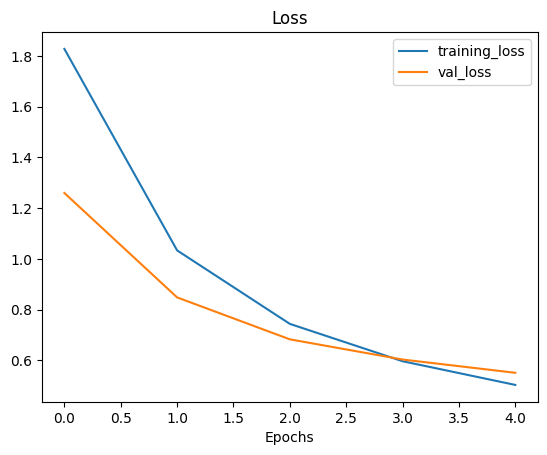

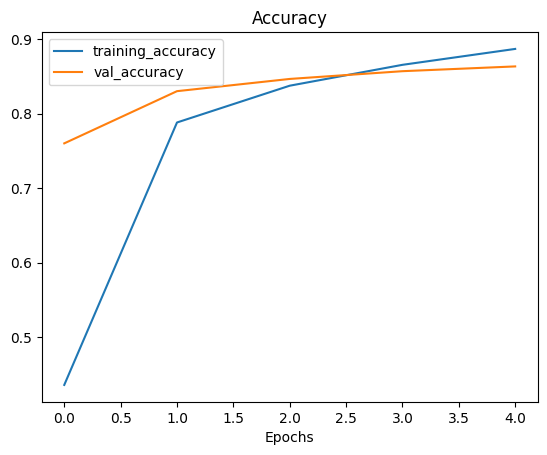

In [ ]:
# Plotting loss curves for EfficientNetB0
plot_loss_curves(history_2)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# How many layers are in my Transfer learning models?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* 'As is' transfer learning - using an existing model with no changes whatsoever (eg. using ImageNet model on 1000 ImageNet classes, none of your own)
* 'Feature extraction' transfer learning - use the prelearned patterns of an existing model (eg. EfficientNetB0 trained on ImageNet) and adjust the output later for your own problem (eg. 1000 classes -> 10 classes of food)
* 'Fine-tuning' transfer learning = use the prelearned patterns of an existing model and 'fine-tune' many or all of the underlying laters (including new putput layers)

## Comparing our models results using TensorBoard

> **Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EfficientNetB0 vs ResNet50V2' \
  --description 'Comparing two different TF Hub feature extraction model architectures' \
  --one_shot

2023-10-09 09:05:56.088602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   VBYQ-CVMM


Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8,